This book reproduces the results on the D retention in W under ELM-like loads, presented in [V.Kulagin JNM 2025](https://www.sciencedirect.com/science/article/abs/pii/S0022311524004719). Since the computed data is heavy, the raw results can be accessed via Zenodo archive. To use this book, one should define an appropriate PATH to the data in the archive.

In [1]:
path = "/mnt/X/ITER-ELMs/"

## Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import sympy as sp
import pandas as pd
import matplotlib.colors as Colors
import matplotlib.cm as cmx
from matplotlib.ticker import LogLocator
from matplotlib.legend_handler import HandlerTuple
import h5py
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy import integrate, special
import copy

mpl_params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
            r"\usepackage{amsmath}",
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[russian]{babel}",
        ]
    ),
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.family": "Times New Roman",
    "font.size": 12,
    "legend.frameon": False,
}

plt.rcParams.update(mpl_params)
mm2inch = 1e-1 / 2.54


def colors_grad(first, last, i, cmap="Reds"):
    colors = plt.get_cmap(cmap)
    cNorm = Colors.Normalize(vmin=first, vmax=last)
    colors_grad = cmx.ScalarMappable(norm=cNorm, cmap=colors)
    color_val = colors_grad.to_rgba(i)
    return color_val

## Fluxes during ELMs

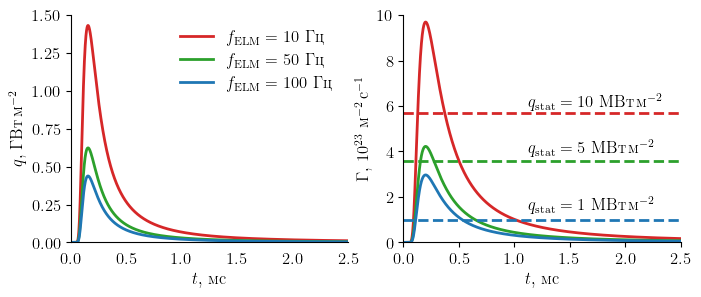

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(200 * mm2inch, 75 * mm2inch), sharex=True)


def q_elm(t):
    tau_IR = 250e-6
    tau = 0.8 * tau_IR
    return (1 + (tau / t) ** 2) * (tau / t) ** 2 * np.exp(-((tau / t) ** 2))


def G_elm(t):
    tau_IR = 250e-6
    tau = 0.8 * tau_IR
    return (tau / t) ** 2 * np.exp(-((tau / t) ** 2))


n_eped = 8e19  # m^-3
W_plasma = 350e6  # J
alpha = 4.2  # degree
R_geo = 6.2  # m
P_sol = 100e6  # W/m^2
T_eped = 4.7e3  # eV
q = 1.6e-19  # C
P_ELM = 0.3 * P_sol

colors = ["tab:red", "tab:green", "tab:blue"]
t = np.linspace(0.000001, 0.0025, 2000)

r_en_elm = 1.40e-1
lw = 2
tau = 0.8 * 250e-6

for i, f_ELM in enumerate([10, 50, 100]):

    dE_ELM = P_ELM / f_ELM / W_plasma
    eps_long = (
        0.28
        * (n_eped / 1e20) ** 0.75
        * (T_eped / 1e3) ** 0.98
        * (dE_ELM * 100) ** 0.52
        * R_geo**1
        * 1e6
    )  # J/m^2
    eps_trans = eps_long * np.sin(alpha * np.pi / 180)

    q_elm_max = eps_trans / (
        tau**2 * f_ELM / 2 * sp.exp(-((tau * f_ELM) ** 2))
        + 3 / 4 * sp.sqrt(np.pi) * tau * (1 - special.erf(f_ELM * tau))
    )
    G_elm_max = q_elm_max / T_eped / (1 - r_en_elm) / q
    # print(q_elm_max/1e6, G_elm_max/1e23)

    color = colors[i]
    axs[0].plot(
        t * 1e3,
        q_elm(t) * q_elm_max / 1e9,
        lw=lw,
        label=r"$f_{\textrm{ELM}}=$ " + str(f_ELM) + " Гц",
        color=color,
    )
    Gamma_eqv = G_elm_max * (
        1 / 2 * np.sqrt(np.pi) * tau * f_ELM * special.erfc(f_ELM * tau)
    )

    axs[1].plot(t * 1e3, G_elm(t) * G_elm_max / 1e23, lw=lw, color=color)

stat_params = {
    1e6: [51, 6.85e-1, 4.84e-1, 2.64e-9, 1.42e-9],
    5e6: [75, 6.66e-1, 4.61e-1, 3.27e-9, 1.76e-9],
    10e6: [97, 6.54e-1, 4.47e-1, 3.76e-9, 2.03e-9],
}
q_stat = [1e6, 5e6, 10e6]

for i, qs in enumerate(q_stat):
    E = stat_params[qs][0]
    r_en_stat = stat_params[qs][2]
    Te = E / 4.85
    htf = (4.85 * (1 - r_en_stat) + 2.15) * Te + 13.6
    Gamma_stat = qs / htf / q
    axs[1].plot(
        [0, 3],
        [Gamma_stat / 1e23, Gamma_stat / 1e23],
        ls="dashed",
        lw=lw,
        color=colors[2 - i],
    )

axs[0].set_ylim(0, 1.500)
axs[0].set_yticks([i / 1e3 for i in range(0, 1750, 250)])
axs[1].set_ylim(0, 10)
axs[0].tick_params(bottom=False)
axs[0].set_ylabel(r"$q$, ГВт\,м$^{-2}$")
axs[1].set_ylabel(r"$\Gamma$, 10$^{23}$ м$^{-2}$\,с$^{-1}$")
axs[1].set_xlabel(r"$t$, мс")
axs[0].set_xlabel(r"$t$, мс")
axs[0].legend(fancybox=False, shadow=True, edgecolor="black")
axs[1].set_xlim(0, 2.5)

axs[1].text(
    0.45,
    0.615,
    r"$q_{\textrm{stat}}=10$ МВт\,м$^{-2}$",
    fontweight="bold",
    va="center",
    color="black",
    transform=axs[1].transAxes,
)
axs[1].text(
    0.45,
    0.415,
    r"$q_{\textrm{stat}}=5$ МВт\,м$^{-2}$",
    fontweight="bold",
    va="center",
    color="black",
    transform=axs[1].transAxes,
)
axs[1].text(
    0.45,
    0.165,
    r"$q_{\textrm{stat}}=1$ МВт\,м$^{-2}$",
    fontweight="bold",
    va="center",
    color="black",
    transform=axs[1].transAxes,
)


plt.savefig(
    "../../../Thesis/images/ELM_fluxes.pdf", bbox_inches="tight", pad_inches=0.01
)
plt.show()

## Temperature evolution

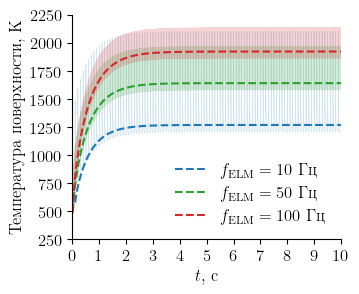

In [12]:
files = [
    path + "Статья/T_data/T_surf_q10_f10.txt",
    path + "Статья/T_data/T_surf_q10_f50.txt",
    path + "Статья/T_data/T_surf_q10_f100.txt",
]

fig, ax = plt.subplots(figsize=(88 * mm2inch, 74 * mm2inch))

fs = [10, 50, 100]
lw = 1.5
colors = ["tab:blue", "tab:green", "tab:red"]
labels = [
    r"$f_{\mathrm{ELM}}=10$ Гц",
    r"$f_{\mathrm{ELM}}=50$ Гц",
    r"$f_{\mathrm{ELM}}=100$ Гц",
]

for i, file in enumerate(files):

    data = pd.read_csv(file, header=None, sep="\s+")
    N_mean = int(len(data[(data[0] > 10 / fs[i]) & (data[0] < 11 / fs[i])]))

    ax.plot(data[0], data[1], alpha=0.2, color=colors[i], lw=0.5)
    ax.plot(
        data[0],
        data[1].rolling((N_mean)).mean(),
        lw=1.5,
        label=labels[i],
        color=colors[i],
        ls="dashed",
    )

ax.set_xlim(0, 10)
ax.set_ylim(250, 2250)
ax.set_yticks([i for i in range(250, 2500, 250)])
ax.set_xticks([i for i in range(11)])
ax.set_xlabel(r"$t$, с")
ax.set_ylabel("Температура поверхности, К")
ax.legend(fancybox=False, shadow=True, edgecolor="black", loc=4, handlelength=1.9)


plt.savefig("../../../Thesis/images/T_surf.pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

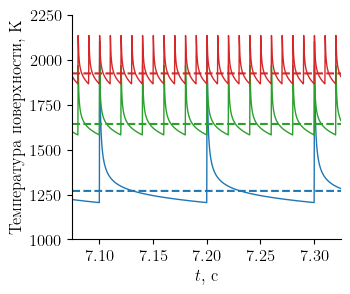

In [13]:
fig, ax = plt.subplots(figsize=(88 * mm2inch, 74 * mm2inch))

for i, file in enumerate(files):

    data = pd.read_csv(file, header=None, sep="\s+")
    N_mean = int(len(data[(data[0] > 10 / fs[i]) & (data[0] < 11 / fs[i])]))

    ax.plot(data[0], data[1], alpha=1, color=colors[i], lw=1)
    ax.plot(
        data[0],
        data[1].rolling((N_mean)).mean(),
        lw=1.5,
        label=labels[i],
        color=colors[i],
        ls="dashed",
    )


ax.set_xlim(7.075, 7.325)
ax.set_ylim(1000, 2250)
ax.set_yticks([i for i in range(1000, 2500, 250)])
ax.set_ylabel("Температура поверхности, К")
ax.set_xlabel(r"$t$, c")

plt.savefig(
    "../../../Thesis/images/T_surf_cut.pdf", bbox_inches="tight", pad_inches=0.01
)
plt.show()

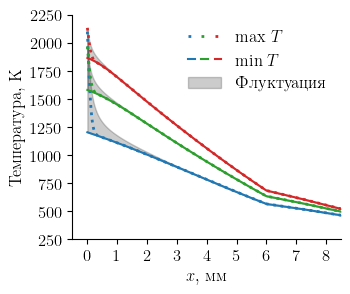

In [14]:
from matplotlib.legend_handler import HandlerTuple

fig, ax = plt.subplots(figsize=(88 * mm2inch, 74 * mm2inch))

data = [
    pd.read_csv(path + "Статья/T_data/T_vs_x_q10_f10.txt", header=None, sep="\s+"),
    pd.read_csv(path + "Статья/T_data/T_vs_x_q10_f50.txt", header=None, sep="\s+"),
    pd.read_csv(path + "Статья/T_data/T_vs_x_q10_f100.txt", header=None, sep="\s+"),
]
P1 = []
P2 = []
for i, dat in enumerate(data):
    dat["Maxs"] = dat.drop(columns=0).max(axis=1)
    dat["Mins"] = dat.drop(columns=0).min(axis=1)

    (p1,) = ax.plot(dat[0], dat[5], color=colors[i], lw=2, ls="dotted")
    (p2,) = ax.plot(dat[0], dat[1], color=colors[i], lw=lw)
    P1.append(p1)
    P2.append(p2)
    p3 = ax.fill_between(dat[0], dat["Maxs"], dat["Mins"], color=[0, 0, 0, 0.2])

l = ax.legend(
    [tuple(P1), tuple(P2), p3],
    ["$\max\,T$", "$\min\,T$", "Флуктуация"],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    handlelength=2,
    fancybox=False,
    shadow=True,
    edgecolor="black",
)


ax.set_xticks([i for i in range(9)])
ax.set_xlim(-0.5, 8.5)
ax.set_ylim(250, 2250)
ax.set_xlabel(r"$x$, мм")
ax.set_ylabel("Температура, К")
ax.set_yticks([i for i in range(250, 2500, 250)])

plt.savefig(
    "../../../Thesis/images/T_profile.pdf", bbox_inches="tight", pad_inches=0.01
)
plt.show()

## ELM frequency

In [ ]:
mpl_params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
            r"\usepackage{amsmath}",
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[russian]{babel}",
        ]
    ),
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.family": "Times New Roman",
    "font.size": 11,
    "legend.frameon": False,
}

plt.rcParams.update(mpl_params)


def plot_content(axis, ELM_files, stat, cmap, color):
    fs = [i for i in range(10, 110, 10)]
    lw = 1.5
    for i, file in enumerate(ELM_files):
        data = pd.read_csv(file, header=0, sep=",")
        data = data.drop(
            columns=[
                "Flux surface 1: solute",
                "Total solute volume 1",
                "Total 1 volume 1",
                "Recycling coefficient surface 1",
            ]
        )
        N_mean = int(len(data[(data["t(s)"] > 1 / fs[i]) & (data["t(s)"] < 2 / fs[i])]))
        color = colors_grad(-5, 10, i, cmap=cmap)
        label = r"$f_{ELM}=$ " + str(fs[i]) + " Гц"
        data = data.rolling(N_mean).mean()
        axis[0].plot(
            data["t(s)"][::2], data["Total T surface 1"][::2], lw=lw, color=color
        )
        data = data.drop(columns=["Total T surface 1"])
        axis[1].plot(
            data["t(s)"][::2],
            data["Total retention volume 1"][::2],
            label=label,
            lw=lw,
            color=color,
        )
        del data
    axins = axis[0].inset_axes([0, 1.025, 1, 0.05])

    colors = plt.get_cmap(cmap)
    cNorm = Colors.Normalize(vmin=0, vmax=9)
    cbar = plt.colorbar(
        cmx.ScalarMappable(cmap=colors, norm=cNorm),
        cax=axins,
        ticks=np.arange(10),
        label=r"$f_{\mathrm{ELM}}$, Гц",
        orientation="horizontal",
    )
    cbar.set_ticklabels([i for i in range(10, 110, 10)])
    axins.xaxis.set_ticks_position("top")
    axins.xaxis.set_label_position("top")

    stat_data = pd.read_csv(stat, header=0, sep=",")
    stat_data = stat_data.drop(
        columns=["Flux surface 1: solute", "Total solute volume 1", "Total 1 volume 1"]
    )
    ls = "dashed"
    axis[0].plot(
        stat_data["t(s)"], stat_data["Total T surface 1"], ls=ls, color=color, lw=lw
    )
    stat_data = stat_data.drop(columns=["Total T surface 1"])
    axis[1].plot(
        stat_data["t(s)"],
        stat_data["Total retention volume 1"],
        ls=ls,
        color=color,
        lw=lw,
    )
    del stat_data


def plot_distrs(axis, ELM_files, stat, cmap, color):
    lw = 1.5
    if color == "tab:blue":
        s = "386"
    else:
        s = "0"
    f = h5py.File(stat)
    axis.plot(
        f["Mesh"]["0"]["mesh"]["geometry"][()][:, 0] * 1e3,
        f["VisualisationVector"][s][()],
        lw=lw,
        color=color,
        ls="dashed",
    )
    f.close()
    for i, file in enumerate(ELM_files):
        f = h5py.File(file)
        axis.plot(
            f["Mesh"]["0"]["mesh"]["geometry"][()][:, 0] * 1e3,
            f["VisualisationVector"]["0"][()],
            color=colors_grad(-5, 10, i, cmap=cmap),
            lw=lw,
        )
        f.close()


fig = plt.figure(figsize=(200 * mm2inch, 180 * mm2inch))

gs = fig.add_gridspec(2, 1, hspace=0.2, height_ratios=[2, 1])
gs0 = gs[0].subgridspec(2, 3, hspace=0.2, wspace=0.15)  # spacing within the groups
gs1 = gs[1].subgridspec(1, 3, hspace=0, wspace=0.15)

ax1 = gs0.subplots()
ax2 = gs1.subplots()

files = [
    [
        path
        + "FESTIM/Frequency/1e6/ELM_682000_1e6MW_{}Hz_1000s/results/derived_quantities.csv".format(
            i
        )
        for i in range(10, 110, 10)
    ],
    [
        path
        + "FESTIM/Frequency/5e6/ELM_682000_5e6MW_{}Hz_1000s/results/derived_quantities.csv".format(
            i
        )
        for i in range(10, 110, 10)
    ],
    [
        path
        + "FESTIM/Frequency/10e6/ELM_682000_10e6MW_{}Hz_1000s/results/derived_quantities.csv".format(
            i
        )
        for i in range(10, 110, 10)
    ],
]

stat_files = [
    path + "FESTIM/Frequency/STAT_682468_1000s_1e6MW/results/derived_quantities.csv",
    path + "FESTIM/Frequency/STAT_682373_1000s_5e6MW/results/derived_quantities.csv",
    path + "FESTIM/Frequency/STAT_682030_1000s_10e6MW/results/derived_quantities.csv",
]

distrs_stat = [
    path + "FESTIM/Frequency/STAT_716495_1000s_1e6MW/results/ret.h5",
    path + "FESTIM/Frequency/STAT_716472_1000s_5e6MW/results/ret.h5",
    path + "FESTIM/Frequency/STAT_682373_1000s_10e6MW/results/ret.h5",
]

distrs = [
    [
        path
        + "FESTIM/Frequency/1e6/profiles/ELM_682000_1e6MW_{}Hz_1000s/results/ret.h5".format(
            i
        )
        for i in range(10, 110, 10)
    ],
    [
        path
        + "FESTIM/Frequency/5e6/ELM_682000_5e6MW_{}Hz_1000s/results/ret.h5".format(i)
        for i in range(10, 110, 10)
    ],
    [
        path
        + "FESTIM/Frequency/10e6/ELM_682000_10e6MW_{}Hz_1000s/results/ret.h5".format(i)
        for i in range(10, 110, 10)
    ],
]

letters = [
    r"\textbf{(а)} $q_{\mathrm{stat}}=1$ МВт\,м$^{-2}$",
    r"\textbf{(б)} $q_{\mathrm{stat}}=5$ МВт\,м$^{-2}$",
    r"\textbf{(в)} $q_{\mathrm{stat}}=10$ МВт\,м$^{-2}$",
]
colors = ["tab:blue", "tab:green", "tab:red"]
cmaps = ["Blues", "Greens", "Reds"]
for i in range(3):
    plot_distrs(ax2[i], distrs[i], distrs_stat[i], cmaps[i], colors[i])
    plot_content(ax1[:, i], files[i], stat_files[i], cmaps[i], colors[i])

    ax1[0, i].tick_params(which="both", bottom=False, labelbottom=False)
    if i != 0:
        ax1[0, i].tick_params(which="both", left=False, labelleft=False)
        ax1[1, i].tick_params(which="both", left=False, labelleft=False)
        ax2[i].tick_params(axis="y", which="both", left=False, labelleft=False)

    ax1[1, i].set_xlabel(r"$t$, с", fontsize=11)
    ax1[0, i].tick_params(axis="x", which="both", bottom=False)
    for j in range(0, 2):
        ax1[j, i].set_xscale("log")
        ax1[j, i].set_xlim(0.1, 1e3)
    ax1[1, i].set_yscale("log")
    ax1[1, i].set_ylim(1e18, 1e22)
    ax1[0, i].set_ylim(250, 2250)
    ax1[1, i].set_yticks([1e18, 1e19, 1e20, 1e21, 1e22])
    ax1[0, i].set_yticks([250, 750, 1250, 1750, 2250])
    ax1[0, i].text(0.05, 0.89, letters[i], transform=ax1[0][i].transAxes)

    ax2[i].set_yscale("log")
    ax2[i].set_ylim(1e20, 1e25)
    ax2[i].set_yticks([1e20, 1e21, 1e22, 1e23, 1e24, 1e25])
    ax2[i].yaxis.set_minor_locator(LogLocator(numticks=999, subs="auto"))
    ax2[i].set_xlim(-0.25, 6.25)
    ax2[i].set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax2[i].set_xlabel(r"$x$, мм", fontsize=11)


ax1[1, 0].set_ylabel(r"Содержание D, м$^{-2}$", fontsize=11)
ax1[0, 0].set_ylabel(r"Температура поверхности, К", fontsize=11)
ax2[0].set_ylabel(r"Концентрация D, м$^{-3}$", fontsize=11)

fig.align_ylabels()

plt.savefig(
    "../../../Thesis/images/ELMs_frequency.pdf", bbox_inches="tight", pad_inches=0.01
)
plt.show()

KeyboardInterrupt: 

## Recycling coefficient

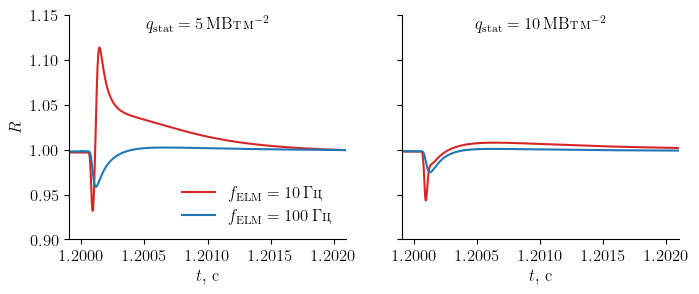

In [ ]:
data_stat = []
data_ELM = []

freqs = [f for f in [10, 100]]
q_vals = [5, 10]
colors = ["tab:blue", "tab:red"]

fig, axs = plt.subplots(
    1, 2, figsize=(200 * mm2inch, 74 * mm2inch), sharey=True, sharex=True
)

for i, q in enumerate(q_vals):
    for j, freq in enumerate(freqs):
        data = np.loadtxt(
            path
            + f"FESTIM/RecyclingCoefficient/ELM_1228576_{freq}Hz_{q}e6MW_1.5eV_1e-4/results/derived_quantities_exposure.csv",
            skiprows=1,
            delimiter=",",
        )

        t = data[:, 0]
        indx = np.where(t > 4)[0]
        axs[i].plot(
            data[:, 0],
            data[:, -1],
            lw=1.5,
            color=colors[1 - j],
            label=rf"$f_\mathrm{{ELM}}={freq}$\,Гц",
        )

    axs[i].set_title(rf"$q_\mathrm{{stat}}={q}$\,МВт\,м$^{{-2}}$", fontsize=12, y=0.9)
    axs[i].set_xlabel(r"$t$, с")

axs[0].set_ylim(0.9, 1.15)
axs[0].set_xlim(1.1999, 1.2021)
axs[0].set_ylabel(r"$R$")
axs[0].legend(loc="lower right")

plt.savefig("../../../Thesis/images/R_freq.pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

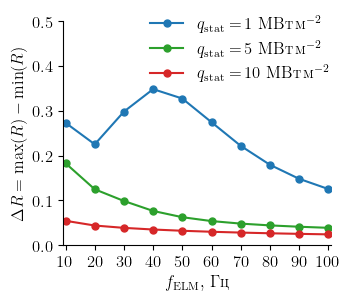

In [ ]:
freqs = [f for f in range(10, 110, 10)]
R_max = np.zeros((len(qs), len(freqs)))
R_min = np.zeros((len(qs), len(freqs)))
q_vals = [1, 5, 10]

fig, ax = plt.subplots(figsize=(88 * mm2inch, 74 * mm2inch))
for i, q in enumerate(q_vals):
    for j, freq in enumerate(freqs):
        data = np.loadtxt(
            path
            + f"FESTIM/RecyclingCoefficient/ELM_1228576_{freq}Hz_{q}e6Mw_1.5eV_1e-4/results/derived_quantities_exposure.csv",
            skiprows=1,
            delimiter=",",
        )

        t = data[:, 0]
        indx = np.where(t > 4)[0]
        R_max[i][j] = max(data[indx, -1])
        R_min[i][j] = min(data[indx, -1])

ampls = np.zeros_like(R_max)

colors = ["tab:blue", "tab:green", "tab:red"]
for i in range(3):
    ax.plot(
        freqs,
        np.array(R_max[i]) - np.array(R_min[i]),
        color=colors[i],
        label=r"$q_\mathrm{stat}=\,$" + f"{q_vals[i]} " + r"МВт\,м$^{-2}$",
        marker="o",
        ms=5,
    )

ax.legend(loc=(0.3, 0.7))
ax.set_xlabel(r"$f_\mathrm{ELM}$, Гц")
ax.set_ylabel(r"$\Delta R = \max (R) - \min(R)$")
ax.set_ylim(0, 0.5)
ax.set_xlim(9, 101)
ax.set_xticks([i for i in range(10, 110, 10)])

# plt.savefig('../../../Thesis/images/R_all.pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()

## Flux-to-energy ratio

In [ ]:
import os

colors = ["tab:blue", "tab:green", "tab:red"]


def get_data(elm_folder):
    loc_file = "/results/derived_quantities.csv"
    files_elms = []
    for x in os.listdir(elm_folder):
        if x.startswith("ELM"):
            files_elms.append(x)
    last_data = []
    for i, file in enumerate(files_elms):
        data = pd.read_csv(elm_folder + file + loc_file, header=0, sep=",")
        last_data.append(max(data["Total retention volume 1"]))
    return np.array(last_data)


def get_stat(stat_folder):
    loc_file = "/results/derived_quantities.csv"
    files_stat = []
    for x in os.listdir(stat_folder):
        if x.startswith("STAT"):
            files_stat.append(x)
    last_stat = []
    for i, file in enumerate(files_stat):
        stat = pd.read_csv(stat_folder + file + loc_file, header=0, sep=",")
        last_stat.append(max(stat["Total retention volume 1"]))
    return np.array(last_stat)


def plot_data(axis, x, ELM_data, stat_data, color):
    axis.plot(
        x,
        [sum(x) / 2 for x in zip(ELM_data[i][0], ELM_data[i][1])],
        color=color,
        lw=1.5,
    )
    axis.fill_between(
        x, ELM_data[i][0], ELM_data[i][1], color=color, alpha=0.2, linewidth=0
    )
    axis.plot(x, stat_data[i], color=color, lw=1.5, ls="dashed")

In [ ]:
ELM_data = []
for q in ["1e6", "5e6", "10e6"]:
    tmp = []
    for f in [10, 100]:
        tmp.append(get_data(path + f"FESTIM/Flux_final/{q}/{f}Hz/"))
    ELM_data.append(tmp)

betas = [1, 1.3333, 2, 2.5, 5, 10]

stat_data = [
    [get_stat(path + f"FESTIM/Flux_re/{q}/")[0] for b in betas]
    for q in ["1e6", "5e6", "10e6"]
]

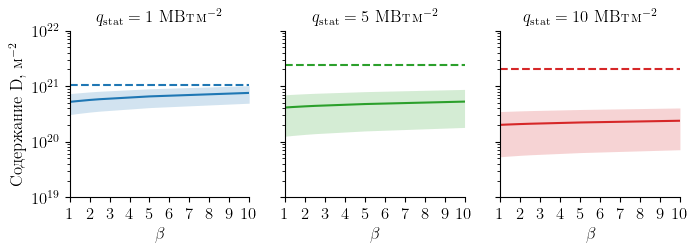

In [ ]:
titles = [rf"$q_{{\mathrm{{stat}}}}={q}$ МВт\,м$^{{-2}}$" for q in [1, 5, 10]]

fig, axs = plt.subplots(
    1, 3, figsize=(200 * mm2inch, 55 * mm2inch), sharex=True, sharey=True
)
for i, ax in enumerate(axs):
    plot_data(ax, betas, ELM_data, stat_data, colors[i])
    ax.set_xlabel(r"$\beta$")
    ax.set_xticks([i for i in range(1, 11)])
    ax.set_title(titles[i], fontsize=12)

axs[0].set_xlim(1, 10)
axs[0].set_ylabel(r"Содержание D, м$^{-2}$")
axs[0].set_yscale("log")
axs[0].set_ylim(1e19, 1e22)

plt.savefig("../../../Thesis/images/beta_var.pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

## Trap properties

In [ ]:
ELM_conc_data = []
ELM_Edt_data = []
for q in ["1e6", "5e6", "10e6"]:
    tmp1 = []
    tmp2 = []
    for f in [10, 100]:
        tmp1.append(get_data(path + f"FESTIM/Trap concentration_final/{q}/{f}Hz/"))
        tmp2.append(get_data(path + f"FESTIM/Detrapping energy_final/{q}/{f}Hz/"))
    ELM_conc_data.append(tmp1)
    ELM_Edt_data.append(tmp2)

etas = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0]
Edts = [i / 10 for i in range(10, 21)]

stat_conc_data = [
    get_stat(path + f"FESTIM/Trap concentration_final/{q}/")
    for q in ["1e6", "5e6", "10e6"]
]
stat_Edt_data = [
    get_stat(path + f"FESTIM/Detrapping energy_final/{q}/")
    for q in ["1e6", "5e6", "10e6"]
]

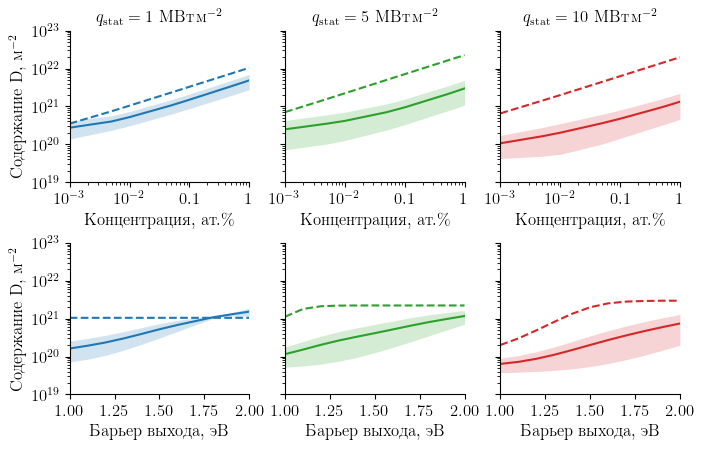

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(200 * mm2inch, 120 * mm2inch), sharey=True)

for i in range(3):
    plot_data(axs[0][i], etas, ELM_conc_data, stat_conc_data, colors[i])
    axs[0, i].set_xscale("log")
    axs[0, i].set_xlim(1e-3, 1)
    axs[0, i].set_xticks([1e-3, 1e-2, 1e-1, 1])
    axs[0, i].set_xticklabels([r"$10^{-3}$", r"$10^{-2}$", "0.1", "1"])
    axs[0, i].set_xlabel(r"Концентрация, ат.\%")
    axs[0, i].set_title(titles[i], fontsize=12)

    plot_data(axs[1][i], Edts, ELM_Edt_data, stat_Edt_data, colors[i])
    axs[1, i].set_xlim(1, 2)
    axs[1, i].set_xlabel(r"Барьер выхода, эВ")
    axs[1, i].set_xticks([1, 1.25, 1.5, 1.75, 2])

for i in range(2):
    axs[i][0].set_ylabel(r"Содержание D, м$^{-2}$")
    axs[i][0].set_ylim(1e19, 1e23)
    axs[i][0].set_yscale("log")

fig.subplots_adjust(hspace=0.4)
fig.align_ylabels()

plt.savefig(
    "../../../Thesis/images/eta_Edt_var.pdf", bbox_inches="tight", pad_inches=0.01
)
plt.show()

## Rate of recombinarion 

In [ ]:
ELM_data = []
for q in ["1e6", "5e6", "10e6"]:
    tmp = []
    for f in [10, 100]:
        tmp.append(get_data(path + f"FESTIM/Recombination_re/{q}/{f}Hz/"))
    ELM_data.append(tmp)

Rs = [-0.23, 0, 0.13, 0.23, 0.33, 0.43, 0.53, 0.63, 0.73, 0.83]

stat_data = [
    get_stat(path + f"FESTIM/Recombination_re/{q}/") for q in ["1e6", "5e6", "10e6"]
]

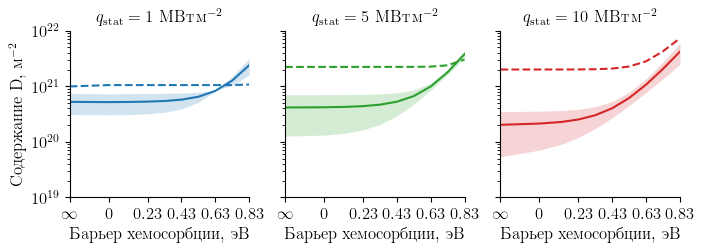

In [ ]:
fig, axs = plt.subplots(
    1, 3, figsize=(200 * mm2inch, 55 * mm2inch), sharex=True, sharey=True
)
for i, ax in enumerate(axs):
    plot_data(ax, Rs, ELM_data, stat_data, colors[i])
    ax.set_xlabel("Барьер хемосорбции, эВ")
    ax.set_xticks([-0.23, 0, 0.23, 0.43, 0.63, 0.83])
    ax.set_xticklabels([r"$\infty$", "0", "0.23", "0.43", "0.63", "0.83"])
    ax.set_title(titles[i], fontsize=12)

axs[0].set_xlim(-0.23, 0.83)
axs[0].set_ylabel(r"Содержание D, м$^{-2}$")
axs[0].set_yscale("log")
axs[0].set_ylim(1e19, 1e22)

plt.savefig("../../../Thesis/images/rec_var.pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

## Baking efficiency

In [4]:
stat_exposure = np.loadtxt(
    path
    + "FESTIM/Baking/ELM_929682_0Hz_5e6MW_1.0eV_1e-4/results/derived_quantities_exposure.csv",
    skiprows=1,
    delimiter=",",
)
stat_baking = np.loadtxt(
    path
    + "FESTIM/Baking/ELM_929682_0Hz_5e6MW_1.0eV_1e-4/results/derived_quantities_baking.csv",
    skiprows=1,
    delimiter=",",
)
ELM_exposure = np.loadtxt(
    path
    + "FESTIM/Baking/ELM_929682_50Hz_5e6MW_1.0eV_1e-4/results/derived_quantities_exposure.csv",
    skiprows=1,
    delimiter=",",
)
ELM_baking = np.loadtxt(
    path
    + "FESTIM/Baking/ELM_929682_50Hz_5e6MW_1.0eV_1e-4/results/derived_quantities_baking.csv",
    skiprows=1,
    delimiter=",",
)

data_stat = np.vstack(
    (
        np.column_stack(
            (stat_exposure[:, 0] / 3600 / 24, stat_exposure[:, 1], stat_exposure[:, 2])
        ),
        np.column_stack(
            (
                (stat_baking[:, 0] + stat_exposure[:, 0].max()) / 3600 / 24,
                stat_baking[:, 1],
                stat_baking[:, 2],
            )
        ),
    )
)

data_ELM = np.vstack(
    (
        np.column_stack(
            (ELM_exposure[:, 0] / 3600 / 24, ELM_exposure[:, 1], ELM_exposure[:, 2])
        ),
        np.column_stack(
            (
                (ELM_baking[:, 0] + ELM_exposure[:, 0].max()) / 3600 / 24,
                ELM_baking[:, 1],
                ELM_baking[:, 2],
            )
        ),
    )
)

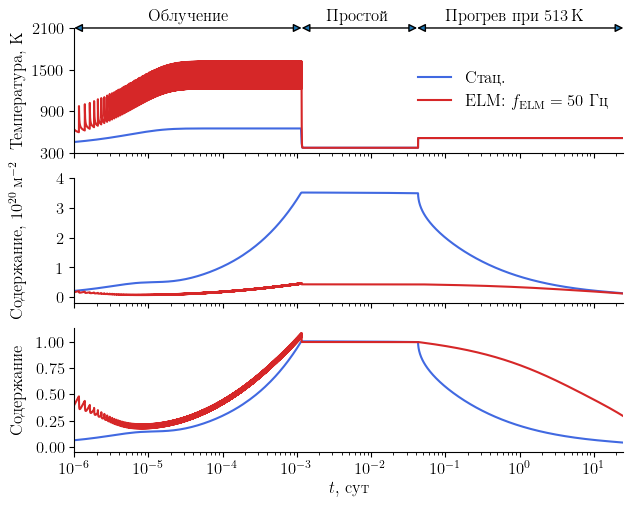

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(180 * mm2inch, 140 * mm2inch), sharex=True)

axs[0].plot(data_stat[:, 0], data_stat[:, 1], color="royalblue", label="Стац.")
axs[0].plot(
    data_ELM[:, 0],
    data_ELM[:, 1],
    color="tab:red",
    label=r"ELM: $f_\mathrm{ELM}=50$ Гц",
)

axs[1].plot(data_stat[:, 0], data_stat[:, 2] / 1e20, color="royalblue")
axs[1].plot(data_ELM[:, 0], data_ELM[:, 2] / 1e20, color="tab:red")

axs[2].plot(data_stat[:, 0], data_stat[:, 2] / stat_baking[0, 2], color="royalblue")
axs[2].plot(data_ELM[:, 0], data_ELM[:, 2] / ELM_baking[0, 2], color="tab:red")

axs[0].annotate(
    text="",
    xy=(1e-6, 2100),
    xytext=(100 / 3600 / 24, 2100),
    arrowprops=dict(arrowstyle="<|-|>", shrinkA=0, shrinkB=0),
)
axs[0].annotate(
    text="Облучение",
    xy=(5e-5, 2100),
    xytext=(1e-5, 2200),
)

axs[0].annotate(
    text="",
    xy=(100 / 3600 / 24, 2100),
    xytext=(3600 / 3600 / 24, 2100),
    arrowprops=dict(arrowstyle="<|-|>", shrinkA=0, shrinkB=0),
)
axs[0].annotate(
    text="Простой",
    xy=(8e-3, 2100),
    xytext=(2.5e-3, 2200),
)

axs[0].annotate(
    text="",
    xy=(3600 / 3600 / 24, 2100),
    xytext=(25, 2100),
    arrowprops=dict(arrowstyle="<|-|>", shrinkA=0, shrinkB=0),
)
axs[0].annotate(
    text=r"Прогрев при $513\,$К",
    xy=(1e-6, 2100),
    xytext=(0.1, 2200),
)

axs[0].set_ylabel("Температура, К")
axs[0].set_xscale("log")
axs[0].set_xlim(1e-6, 25)
axs[0].set_ylim(300, 2100)
axs[1].set_ylabel(r"Содержание, 10$^{20}$\,м$^{-2}$")
axs[2].set_ylabel("Содержание")
axs[2].set_xlabel(r"$t$, сут")
axs[0].legend(loc="center right")
axs[0].set_yticks([i for i in range(300, 2400, 600)])
axs[1].set_yticks([0, 1, 2, 3, 4])
axs[2].set_yticks([0, 0.25, 0.5, 0.75, 1.0])

fig.align_ylabels()

plt.savefig(
    "../../../Thesis/images/baking_single.pdf", bbox_inches="tight", pad_inches=0.01
)
plt.show()

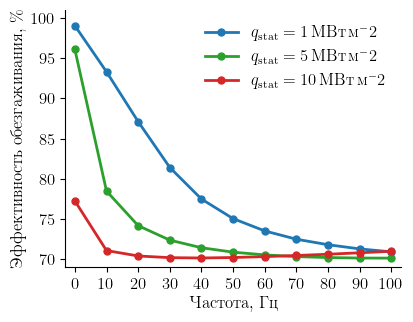

In [8]:
freqs = [i for i in range(0, 110, 10)]
data = np.zeros((3, 11))

folder = path + "FESTIM/Baking/"

qs = [1, 5, 10]
for i, q in enumerate(qs):
    for j, f in enumerate(freqs):
        raw = np.loadtxt(
            folder
            + f"/ELM_929682_{f}Hz_{q}e6MW_1.0eV_1e-4/results/derived_quantities_baking.csv",
            skiprows=1,
            delimiter=",",
        )
        initial_retention = raw[0, 2]
        final_retention = raw[-1, 2]
        ratio = final_retention / initial_retention

        data[i][j] = ratio

colors = ["tab:blue", "tab:green", "tab:red"]
plt.figure(figsize=(110 * mm2inch, 85 * mm2inch))
for i, dat in enumerate(data):
    plt.plot(
        freqs,
        (1 - np.array(dat)) * 100,
        marker="o",
        ms=5,
        lw=2,
        color=colors[i],
        label=rf"$q_\mathrm{{stat}}={qs[i]}\,$МВт$\,$м$^{-2}$",
    )

plt.xlim(-3, 103)
plt.ylim(69, 101)
plt.xticks([i for i in range(0, 110, 10)])
plt.ylabel("Эффективность обезгаживания, \%")
plt.xlabel("Частота, Гц")
plt.legend()

plt.savefig(
    "../../../Thesis/images/baking_efficiency.pdf", bbox_inches="tight", pad_inches=0.01
)
plt.show()

## ELM-average loads

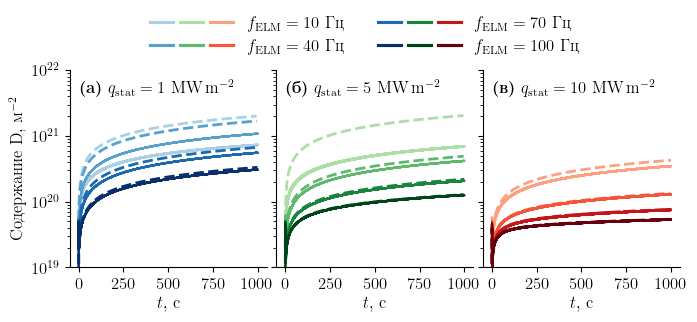

In [ ]:
def plot_datas(axis, filename_ELM, filename_EQV, freq, i, cmap):
    data = pd.read_csv(filename_ELM, header=0, sep=",")

    field = "Total retention volume 1"
    color = colors_grad(-3, 6, 2 * i, cmap=cmap)
    label = rf"$f_\mathrm{{ELM}}={freq}$ Гц"
    axis.plot(data["t(s)"], data[field], label=label, color=color, lw=1.5)

    data = pd.read_csv(filename_EQV, header=0, sep=",")
    axis.plot(data["t(s)"], data[field], label=label, ls="dashed", color=color, lw=2)


def increase_width(handles):
    handles = [copy.copy(h) for h in handles]
    [h.set_linewidth(2.25) for h in handles]
    return handles


fig, ax = plt.subplots(
    1, 3, figsize=(200 * mm2inch, 65 * mm2inch), sharex=True, sharey=True
)

freqs = [10, 40, 70, 100]

f_names = [
    [
        path
        + f"/FESTIM/Frequency/{q}e6/ELM_682000_{q}e6MW_{f}Hz_1000s/results/derived_quantities.csv"
        for f in freqs
    ]
    for q in [1, 5, 10]
]

f1_names = [
    [
        path
        + f"/FESTIM/Equivalent/eqv1/EQV_832165_{q}e6MW_{f}Hz_1000s_1.5eV_1e-4/results/derived_quantities.csv"
        for f in freqs
    ]
    for q in [1, 5, 10]
]

cm = ["Blues", "Greens", "Reds"]
letters = [
    r"\textbf{(а)} $q_{\mathrm{stat}}=1$ MW\,m$^{-2}$",
    r"\textbf{(б)} $q_{\mathrm{stat}}=5$ MW\,m$^{-2}$",
    r"\textbf{(в)} $q_{\mathrm{stat}}=10$ MW\,m$^{-2}$",
]

for j in range(0, 3):
    for i in range(len(freqs)):
        plot_datas(ax[j], f_names[j][i], f1_names[j][i], freqs[i], i, cm[j])

    ax[j].set_xlabel(r"$t$, с")
    ax[j].set_xticks([0, 250, 500, 750, 1000])
    ax[j].text(0.05, 0.89, letters[j], transform=ax[j].transAxes)


h1, l1 = ax[0].get_legend_handles_labels()
h2, _ = ax[1].get_legend_handles_labels()
h3, _ = ax[2].get_legend_handles_labels()
h1 = increase_width(h1)
h2 = increase_width(h2)
h3 = increase_width(h3)

leg = fig.legend(
    handles=[(h1[i], h2[i], h3[i]) for i in range(0, len(h1), 2)],
    labels=[l1[i] for i in range(0, len(h1), 2)],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(0, 0.95, 1, 0.2),
    loc="upper center",
    ncol=2,
    handlelength=5,
)

ax[0].set_ylabel(r"Содержание D, м$^{-2}$")
ax[0].set_yscale("log")
ax[0].set_ylim(1e19, 1e22)

fig.subplots_adjust(wspace=0.05)

plt.savefig("../../../Thesis/images/Eqv_load.pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

## Steady-state profiles

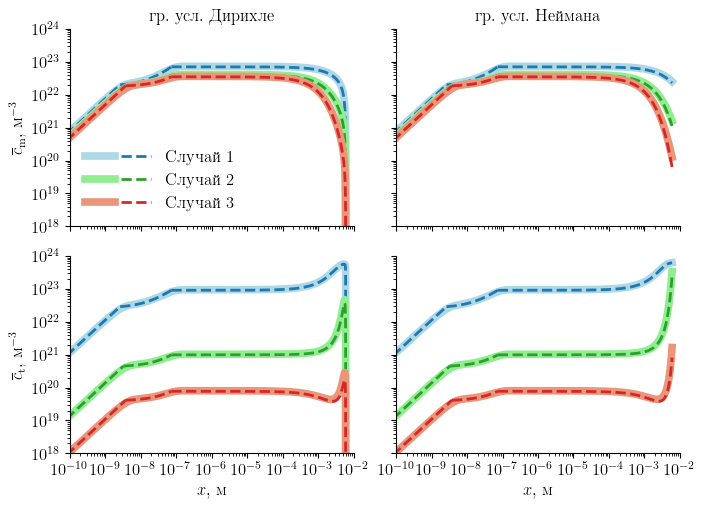

In [5]:
def gammas(f_ELM, q_stat):
    E_ELM = 9400

    stat_params = {
        1e6: [51, 6.85e-1, 4.84e-1, 2.64e-9, 1.42e-9],
        5e6: [75, 6.66e-1, 4.61e-1, 3.27e-9, 1.76e-9],
        10e6: [97, 6.54e-1, 4.47e-1, 3.76e-9, 2.03e-9],
    }

    ELM_params = {
        4700: [3.82e-1, 1.99e-1, 4.34e-8, 2.32e-8],
        7050: [3.34e-1, 1.64e-1, 5.88e-8, 3.10e-8],
        9400: [2.98e-1, 1.40e-1, 7.34e-8, 3.82e-8],
        11750: [2.69e-1, 1.21e-1, 8.75e-8, 4.49e-8],
    }

    tau_IR = 250e-6
    tau = 0.8 * tau_IR
    n_eped = 8e19  # m^-3
    W_plasma = 350e6  # J
    alpha = 4.2  # degree
    R_geo = 6.2  # m
    P_sol = 100e6  # W/m^2
    T_eped = 4.7e3  # eV
    P_ELM = 0.3 * P_sol
    dE_ELM = P_ELM / f_ELM / W_plasma
    eps_long = (
        0.28
        * (n_eped / 1e20) ** 0.75
        * (T_eped / 1e3) ** 0.98
        * (dE_ELM * 100) ** 0.52
        * R_geo**1
        * 1e6
    )
    eps_trans = eps_long * np.sin(alpha * np.pi / 180)
    q_elm_max = eps_trans / (
        tau**2 * f_ELM / 2 * sp.exp(-((tau * f_ELM) ** 2))
        + 3 / 4 * sp.sqrt(np.pi) * tau * special.erfc(f_ELM * tau)
    )
    q = 1.6e-19

    E_stat = stat_params[q_stat][0]
    r_STAT = stat_params[q_stat][1]
    r_en_stat = stat_params[q_stat][2]

    r_ELM = ELM_params[E_ELM][0]
    r_en_ELM = ELM_params[E_ELM][1]

    Te = E_stat / 4.85
    htf = (4.85 * (1 - r_en_stat) + 2.15) * Te + 13.6
    Gamma_stat = q_stat / htf / q

    q_eqv = q_stat + f_ELM * eps_trans
    Gamma_eqv = (
        q_elm_max
        / T_eped
        / (1 - r_en_ELM)
        / q
        * (1 / 2 * np.sqrt(np.pi) * tau * f_ELM * special.erfc(f_ELM * tau))
    )
    D0 = 1.93e-7 / np.sqrt(2)

    X1 = stat_params[q_stat][3]
    X2 = ELM_params[E_ELM][2]

    gamma1 = Gamma_stat / D0 * (1 - r_STAT)
    gamma2 = Gamma_eqv / D0 * (1 - r_ELM)

    return gamma1, gamma2, q_eqv, X1, X2


def find_T(file):
    f = h5py.File(file)
    data = f["VisualisationVector"]["0"][()]
    return min(data)[0], kappa(max(data[0]))


def kappa(T):
    return (
        149.441
        - 45.466e-3 * T
        + 13.193e-6 * T**2
        - 1.484e-9 * T**3
        + 3.866e6 / (T + 0.1) ** 2
    )


qs_l = ["1e6_2", "5e6_2", "10e6_2"]
legends = [f"Случай {i}" for i in range(1, 4)]

T_files = [
    path + f"/FESTIM/Eqv comparison/DBC/{q}e6_2/results/T.h5" for q in [1, 5, 10]
]

qs = [1e6, 5e6, 10e6]
f_ELM = [10, 50, 100]
n_w = 6.31e28
n_IS = n_w * 6
Edt = [1.0, 1.0, 1.0]
eta_tr = [1e-5, 1e-4, 1e-4]
n_traps = [i * n_w for i in eta_tr]
L = 6e-3
Ed = 0.2
k = 1 / 11600
D0 = 1.93e-7 / np.sqrt(2)

colors = ["tab:blue", "tab:green", "tab:red"]

fig, ax = plt.subplots(
    2, 2, figsize=(200 * mm2inch, 140 * mm2inch), sharey=True, sharex=True
)

for i in range(3):
    Tmin, kappa_v = find_T(T_files[i])
    gamma1, gamma2, q_eqv, X1, X2 = gammas(f_ELM[i], qs[i])
    beta = 0.0045 * q_eqv / kappa_v

    xx = np.linspace(0, 6e-3, num=6001)
    xx1 = np.geomspace(1e-11, X1, num=100)
    xx2 = np.geomspace(X1, X2, num=1000)
    xx3 = np.sort(
        np.concatenate(
            [np.geomspace(X2, L, num=2000), np.linspace(3e-3, 6e-3, num=300)]
        )
    )

    def T(x, Tmin, q_eqv):
        if not hasattr(x, "__iter__"):
            return fsolve(
                lambda y: integrate.quad(kappa, Tmin, y)[0] - q_eqv * (L - x), Tmin
            )
        else:
            out = np.zeros_like(x)
            for count, x_ in enumerate(x):
                out[count] = fsolve(
                    lambda y: integrate.quad(kappa, Tmin, y)[0] - q_eqv * (L - x_), Tmin
                )
        return out

    y = T(xx, Tmin, q_eqv)
    TT = interp1d(xx, y)

    def integrand(x):
        return np.exp(Ed / k / TT(x) + beta * x)

    def intgr(x1, x2):
        return integrate.quad(integrand, x1, x2)[0]

    def teta2(x0):
        return intgr(x0, L) / intgr(0, L)

    def teta4(x0):
        return 1 - teta2(x0)

    def c1(x, x0):
        out = np.zeros_like(x)
        for count, x_ in enumerate(x):
            out[count] = teta2(x0) * np.exp(-beta * x_) * intgr(0, x_)
        return out

    def c2(x, x0):
        out = np.zeros_like(x)
        for count, x_ in enumerate(x):
            out[count] = np.exp(-beta * x_) * (teta4(x0) * intgr(x_, L))
        return out

    def c1_N(x, x0):
        out = np.zeros_like(x)
        for count, x_ in enumerate(x):
            out[count] = np.exp(-beta * x_) * intgr(0, x_)
        return out

    def c2_N(x, x0):
        out = np.zeros_like(x)
        for count, x_ in enumerate(x):
            out[count] = intgr(0, x0) * np.exp(-beta * x_)
        return out

    def nu_dt(x, Edt):
        nu0 = 1e13
        return nu0 * np.exp(-Edt / k / TT(x))

    def nu_tr(x):
        nu0 = D0 / 110e-12**2
        Etr = 0.2
        return nu0 * np.exp(-Etr / k / TT(x))

    def n(c, x, Edt, n_traps):
        return n_traps / (1 + nu_dt(x, Edt) * n_IS / c / nu_tr(x))

    c1_ast = gamma1 * c1(xx1, X1) + gamma2 * c1(xx1, X2)
    c2_ast = gamma1 * c2(xx2, X1) + gamma2 * c1(xx2, X2)
    c3_ast = gamma1 * c2(xx3, X1) + gamma2 * c2(xx3, X2)

    n1 = n(c1_ast, xx1, Edt[i], n_traps[i])
    n2 = n(c2_ast, xx2, Edt[i], n_traps[i])
    n3 = n(c3_ast, xx3, Edt[i], n_traps[i])

    c1_N_ast = gamma1 * c1_N(xx1, X1) + gamma2 * c1_N(xx1, X2)
    c2_N_ast = gamma1 * c2_N(xx2, X1) + gamma2 * c1_N(xx2, X2)
    c3_N_ast = gamma1 * c2_N(xx3, X1) + gamma2 * c2_N(xx3, X2)

    n1_N = n(c1_N_ast, xx1, Edt[i], n_traps[i])
    n2_N = n(c2_N_ast, xx2, Edt[i], n_traps[i])
    n3_N = n(c3_N_ast, xx3, Edt[i], n_traps[i])

    files_mob = [
        path + f"FESTIM/Eqv comparison/{BC}/" + qs_l[i] + "/results/mobile.h5"
        for BC in ["DBC", "NBC"]
    ]

    files_tr = [
        path + f"FESTIM/Eqv comparison/{BC}/" + qs_l[i] + "/results/trapped.h5"
        for BC in ["DBC", "NBC"]
    ]

    colors_n = ["lightblue", "lightgreen", "darksalmon"]
    kwargs = {"color": colors_n[i], "lw": 5.5}

    for ind, file in enumerate(files_mob):
        f = h5py.File(file)
        f.keys()
        mesh1 = f["Mesh"]["0"]["mesh"]["geometry"][()]
        data1 = f["VisualisationVector"]["0"][()]
        label = legends[i]
        ax[0, ind].plot(mesh1[:, 0], data1, label=label, **kwargs)

    for sad, file in enumerate(files_tr):
        f = h5py.File(file)
        f.keys()
        mesh1 = f["Mesh"]["0"]["mesh"]["geometry"][()]
        data1 = f["VisualisationVector"]["0"][()]
        ax[1, sad].plot(mesh1[:, 0], data1, **kwargs)

    f = 0
    kwargs = {"color": colors[i], "lw": 2, "ls": "dashed"}
    if i == 2:
        ax[0, 0].plot(xx1, c1_ast, label="N", **kwargs)
    else:
        ax[0, 0].plot(xx1, c1_ast, label="N", **kwargs)
    ax[0, 0].plot(xx2, c2_ast, **kwargs)
    ax[0, 0].plot(xx3, c3_ast, **kwargs)

    ax[0, 1].plot(xx1, c1_N_ast, **kwargs)
    ax[0, 1].plot(xx2, c2_N_ast, **kwargs)
    ax[0, 1].plot(xx3, c3_N_ast, **kwargs)

    ax[1, 0].plot(xx1, n1, **kwargs)
    ax[1, 0].plot(xx2, n2, **kwargs)
    ax[1, 0].plot(xx3, n3, **kwargs)

    ax[1, 1].plot(xx1, n1_N, **kwargs)
    ax[1, 1].plot(xx2, n2_N, **kwargs)
    ax[1, 1].plot(xx3, n3_N, **kwargs)

for i in range(2):
    ax[1, i].set_xlabel(r"$x$, м")
    ax[1, i].set_xscale("log")
    ax[1, i].set_xlim(1e-10, 1e-2)
    ax[1, i].set_xticks([1e-10 * 10**i for i in range(9)])


ax[0, 0].set_title(r"гр. усл. Дирихле", fontsize=12)
ax[0, 1].set_title(r"гр. усл. Неймана", fontsize=12)
ax[0, 0].set_yscale("log")
ax[0, 0].set_ylim(1e18, 1e24)
ax[0, 0].set_yticks([1e18 * 10**i for i in range(7)])
ax[0, 0].set_ylabel(r"$\overline{c}_{\mathrm{m}}$, м$^{-3}$")
ax[1, 0].set_ylabel(r"$\overline{c}_{\mathrm{t}}$, м$^{-3}$")
ax[1, 0].xaxis.set_minor_locator(LogLocator(numticks=999, subs="auto"))
ax[1, 0].yaxis.set_minor_locator(LogLocator(numticks=999, subs="auto"))

h1, l1 = ax[0, 0].get_legend_handles_labels()
ax[0, 0].legend(
    handles=[(h1[i], h1[i + 1]) for i in range(0, len(h1) - 1, 2)],
    labels=[l1[i] for i in range(0, len(h1) - 1, 2)],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    handlelength=4,
)

fig.subplots_adjust(hspace=0.15, wspace=0.15)

plt.savefig(
    "../../../Thesis/images/retention_saturation.pdf",
    bbox_inches="tight",
    pad_inches=0.01,
)
plt.show()